In [47]:
import pandas as pd
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [29]:
in_file_name = 'data/runs_ju.tsv'
runs = pd.read_csv(in_file_name, delimiter="\t")

In [72]:
runs
x = runs.team_id.values
#x = runs.as_matrix(["team_id", "leg_nro"])
y = runs.pace.values
print(x) # prints: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
x = x.reshape(len(x), 1)
#x = x.reshape(len(x), 2)
y = y.reshape(len(y), 1)

[  5  12 141 ...  84  27  27]


In [73]:
x.shape

(64201, 1)

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2)

In [81]:
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
regr.coef_

array([[0.00326223]])

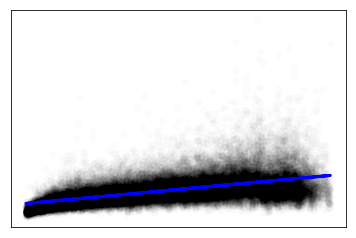

In [82]:


# plot it as in the example at http://scikit-learn.org/
plt.scatter(x_train, y_train,  color='black', alpha=0.01)
plt.plot(x_train, regr.predict(x_train), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [83]:
# Make predictions using the testing set
y_pred = regr.predict(x_test)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))
y_pred

Mean squared error: 6.13
Variance score: 0.30


array([[ 8.81327664],
       [12.29081261],
       [12.51264417],
       ...,
       [12.38541725],
       [10.33673752],
       [ 8.57839617]])

In [84]:
rf = RandomForestRegressor(random_state=0, verbose=1)
rf.fit(x_train, y_train.ravel())

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=1, warm_start=False)

In [85]:
# Make predictions using the testing set
rf_y_pred = rf.predict(x_test)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rf_y_pred))


Mean squared error: 5.91
Variance score: 0.33


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


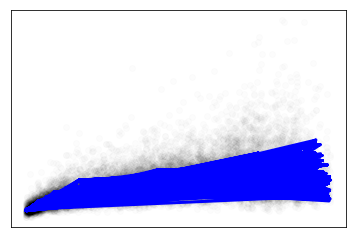

In [87]:
# plot it as in the example at http://scikit-learn.org/
plt.scatter(x_test, y_test,  color='black', alpha=0.01)
plt.plot(x_test, rf.predict(x_test), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()